## CIFAR-100 Dataset Classification using K-Nearest Neighbors (Euclidean)

### Summary
<img align="right" src="../image/NearestNeighbor.png" width=150 height=150>
KNN은 새로운 데이터가 주어졌을 때 기존 데이터 가운데 가장 가까운 k개 이웃의 정보로 새로운 데이터를 예측하는 알고리즘

새로운 데이터가 주어진 경우 기존 모든 데이터와의 거리를 계산한다. 계산된 거리 값이 작은 k개의 데이터를 선정한다. 새로운 데이터의 클래스는 선정된 데이터들의 클래스 중 가장 많이 선택된 클래스로 분류한다.

CIFAR-100 데이터셋을 분류하기 위해 kNN을 사용한다. 그리고 PCA를 이용하여 차원 축소 후 kNN을 이용하여 분류를 진행한다.

<span style="color: #2D3748; background-color:#fff5b1;">Test size를 0.2인 10번 반복 실험한 결과 평균적으로 0.95의 정확도를 보여주고 있고, test 데이터를 분류하는데 0.005초의 시간이 걸린다.</span>

In [47]:
import time
import numpy as np
import matplotlib.pyplot as plt
from utils import Info
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader

In [49]:
class Config(Info):
    def __init__(self):
        super(Info, self).__init__()
        self.device = 'Jetson'
        self.dataset = 'CIFAR_10'
        self.test_size = 0.2
        self.feature_size = 3072
        self.method = 'kNN'
        self.k = 1
        self.distance = 'Euclidean'
        self.reduction_method = [None, None] # method, n_components
        self.iter = 10
    

In [50]:
cig = Config()
cig.info()
cig.print_rutin()

Device ── Jetson
│
├──Dataset
│    └────CIFAR_10
│    └────Train size 80%
│    └────Feature size: 3072
│
├──Method
│    └────kNN
│    └────k = 1
│    └────Euclidean
│
├──Dimension reduction
│    └────Component size: None
│    └────Feature Reduction Ratio: None%
│
└──Iteration
    └────10
Jetson-CIFAR_10(80%)-10 iteration


## Load CIFAR-100 Dataset

In [ ]:
transform = transforms.Compose([transforms.ToTensor()])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

print(trainset.data.shape)
print(testset.data.shape)

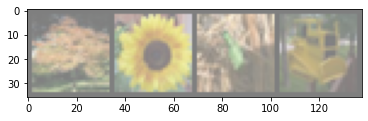

In [25]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(trainloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))

In [26]:
features = trainset.data.reshape(-1, cig.feature_size)
target = trainset.targets

print(np.array(features).shape)
print(np.array(target).shape)

(50000, 3072)
(50000,)


## K-Nearest Neighbor

In [28]:
avg_test_acc = []
avg_time = []

max_seed = cig.iter

for seed in range(max_seed):
    x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=cig.test_size, random_state=seed, shuffle=True)

    k = cig.k

    knn = KNeighborsClassifier(k, weights='distance', n_jobs=-1)
    knn.fit(x_train, y_train)

    start = time.perf_counter()
    test_score = knn.score(x_test, y_test)
    end = time.perf_counter() - start

    avg_test_acc.append(test_score)
    avg_time.append(end)

cig.print_rutin()
print("-----" * 8)
print("Test set score: %f" % np.array(avg_test_acc).mean())
print("All Test dataset Prediction Average Time at once : %.4f" % np.array(avg_time).mean(), "sec")
print("Divide the Prediction Time by Test size : %.4f" % (np.array(avg_time).mean() / len(y_test)), "sec")

Jetson-CIFAR_100(80%)-10 iteration
----------------------------------------
Test set score: 0.163990
All Test dataset Prediction Time at once : 11.2925 sec
Divide the Prediction Time by Test size : 0.0011 sec


### 1개의 Instance를 예측하는데 걸리는 시간 측정

In [37]:
avg_test_acc = []
avg_time = []

max_seed = cig.iter

for seed in range(max_seed):
    x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=cig.test_size, random_state=seed, shuffle=True)

    k = cig.k

    knn = KNeighborsClassifier(k, weights='distance', n_jobs=-1)
    knn.fit(x_train, y_train)

    for x_one, y_one in zip(x_test, y_test):
        x_one = x_one.reshape(1, -1)
        y_one = np.array(y_one).reshape(1, -1)

        start = time.perf_counter()
        test_score = knn.score(x_one, y_one)
        end = time.perf_counter() - start

        avg_test_acc.append(test_score)
        avg_time.append(end)

cig.print_rutin()
print("-----" * 8)
print("Test set score: %f" % np.array(avg_test_acc).mean())
print("One Instance Test dataset Prediction Average Time at once : %.4f" % np.array(avg_time).mean(), "sec")

KeyboardInterrupt: 

### kNN with PCA feature 3

In [38]:
cig.reduction_method = ['PCA', 3]
cig.info()

Device ── Jetson
│
├──Dataset
│    └────CIFAR_100
│    └────Train size 80%
│    └────Feature size: 3072
│
├──Method
│    └────kNN
│    └────k = 1
│    └────Euclidean
│
├──Dimension reduction
│    └────Component size: 3
│    └────Feature Reduction Ratio: 0.1%
│
└──Iteration
    └────10


In [39]:
pca = PCA(n_components=cig.reduction_method[1])
features3 = pca.fit(features).transform(features)

print(features.shape)

(50000, 3072)


In [45]:
avg_test_acc = []
avg_time = []

max_seed = cig.iter

for seed in range(max_seed):
    x_train, x_test, y_train, y_test = train_test_split(features3, target, test_size=cig.test_size, random_state=seed, shuffle=True)

    k = cig.k

    knn = KNeighborsClassifier(k, weights='distance', n_jobs=-1)
    knn.fit(x_train, y_train)

    start = time.perf_counter()
    test_score = knn.score(x_test, y_test)
    end = time.perf_counter() - start

    avg_test_acc.append(test_score)
    avg_time.append(end)

cig.print_rutin()
print("-----" * 8)
print("Test set score: %f" % np.array(avg_test_acc).mean())
print("All Test dataset Prediction Average Time at once : %.4f" % np.array(avg_time).mean(), "sec")
print("Divide the Prediction Time by Test size : %f" % (np.array(avg_time).mean() / len(y_test)), "sec")

Jetson-CIFAR_100(80%)-10 iteration-PCA(feature 2)
----------------------------------------
Test set score: 0.034200
All Test dataset Prediction Average Time at once : 0.0320 sec
Divide the Prediction Time by Test size : 0.000003 sec


### kNN with PCA feature 2

In [41]:
cig.reduction_method = ['PCA', 2]
cig.info()

Device ── Jetson
│
├──Dataset
│    └────CIFAR_100
│    └────Train size 80%
│    └────Feature size: 3072
│
├──Method
│    └────kNN
│    └────k = 1
│    └────Euclidean
│
├──Dimension reduction
│    └────Component size: 2
│    └────Feature Reduction Ratio: 0.1%
│
└──Iteration
    └────10


In [42]:
pca = PCA(n_components=cig.reduction_method[1])
features2 = pca.fit(features).transform(features)

print(features.shape)

(50000, 3072)


In [44]:
avg_test_acc = []
avg_time = []

max_seed = cig.iter

for seed in range(max_seed):
    x_train, x_test, y_train, y_test = train_test_split(features2, target, test_size=cig.test_size, random_state=seed, shuffle=True)

    k = cig.k

    knn = KNeighborsClassifier(k, weights='distance', n_jobs=-1)
    knn.fit(x_train, y_train)

    start = time.perf_counter()
    test_score = knn.score(x_test, y_test)
    end = time.perf_counter() - start

    avg_test_acc.append(test_score)
    avg_time.append(end)

cig.print_rutin()
print("-----" * 8)
print("Test set score: %f" % np.array(avg_test_acc).mean())
print("All Test dataset Prediction Average Time at once : %.4f" % np.array(avg_time).mean(), "sec")
print("Divide the Prediction Time by Test size : %f" % (np.array(avg_time).mean() / len(y_test)), "sec")

Jetson-CIFAR_100(80%)-10 iteration-PCA(feature 2)
----------------------------------------
Test set score: 0.020840
All Test dataset Prediction Average Time at once : 0.0266 sec
Divide the Prediction Time by Test size : 0.000003 sec
